# Satellite Imagery Classification using Attention-based Deep MIL

Date: 27/04/2025  

Aristotle University of Thessaloniki  

MSc in Artificial Intelligence

## Import Libraries

In [ ]:
import numpy as np
import keras
from keras import layers, ops
from tqdm import tqdm
from matplotlib import pyplot as plt
import gdown
import requests
import os
import yaml
import random
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, precision_recall_curve, auc
from scipy.stats import chi2_contingency
# Set the seed for random function of python
random.seed(1)

## Unzip Bags dataset

First of all, we need to collect the dataset containing the night-time images from the VIIRS satellite images. In this experiment the bagsAugmented variant will be used, which contains the images augmented with various techniques such as random rotation, flip, etc.

In [ ]:
# unzip fetched dataset (need to mount Drive)
!unzip -q /content/drive/MyDrive/VIIRS/bagsAugmented.zip -d /content/

## Collect GDB statistics

The second step, is about collecting the labels that will be used in this experiment. The Gross domestic product (GDP) will be used as found in Eurostat.
The GDP score for each country was collected per year, and afterwards generated a binary version, using as threshold <70 for countries with low GDP, and >=70 for countries with high GDP score.

In [ ]:
# download y labels yaml file from github
url = "https://raw.githubusercontent.com/pleleGit/SatSenseAI/main/statistics/gdbBinary.yaml"
response = requests.get(url)

with open("gdbBinary.yaml", "wb") as f:
    f.write(response.content)

## Create & Import Bags

This section focuses on loading and organizing the satellite imagery dataset for training an **Attention-based Deep Multiple Instance Learning (MIL)** model. It starts by importing the GDP labels from a YAML file, which will be used as the **target variable**. Then, it iterates through the dataset, which is structured by country and year. For each country and year, it randomly selects a fixed number of image instances (50) to form a "bag". These bags are then assigned to training, validation, or test sets based on the country and year. The bags and their corresponding GDP labels are stored in separate lists for each dataset split (train, validation, test). Finally, it prints statistics about the created datasets, including the number of bags, instances per bag, instance shape, and label shape. This organized data is then ready to be used for training the MIL model in subsequent steps.

In [ ]:
# load gdbBinary.yaml
with open("gdbBinary.yaml", "r") as f:
    gdbBinary = yaml.safe_load(f)

In [ ]:
gdb = gdbBinary["gdp_per_capita_index"]

In [ ]:
# load custom Bags dataset for training with Keras
train_bags = []
val_bags = []
test_bags = []
dataset_path = "/content/bagsAugmented"
instances_count = 50
train_bags_labels = []
val_bags_labels = []
test_bags_labels = []
countries = sorted(os.listdir(dataset_path))
years = sorted(os.listdir(os.path.join(dataset_path, countries[0])))
# remove b23 bag from years if exist (for consistency with latter results)
# (when this notebook created b23 was not available)
if "b23" in years:
    years.remove("b23")
print(f"Countries: {countries}")
print(f"Bags per year: {years}")
train_countries = random.sample(countries, 12)
for i, country in enumerate(countries):
    val_year = random.sample(years, 2)
    for year_bag in years:
        bag = []
        # Get the list of files
        all_files = os.listdir(os.path.join(dataset_path, country, year_bag))
        # Pick 30 random files without replacement
        selected_files = random.sample(all_files, instances_count)
        for img_path in selected_files:
            # Loads each image into PIL format
            img = keras.preprocessing.image.load_img(os.path.join(dataset_path, country, year_bag, img_path),
                                                    target_size=(300, 225),
                                                    color_mode="grayscale")
            # Converts a PIL Image instance to a NumPy array
            img_array = keras.preprocessing.image.img_to_array(img)
            img_array = img_array / 255.0  # standardize image to [0, 1]
            bag.append(img_array)
            if len(bag) == instances_count:
                break
        # collect the corresponding gdp per capita index
        id = int(year_bag[1:]) - 14
        if country in train_countries:
            if year_bag in val_year:
                val_bags.append(bag)
                val_bags_labels.append([gdb[country][id]])
            else:
                train_bags.append(bag)
                train_bags_labels.append([gdb[country][id]])
        else:
            test_bags.append(bag)
            test_bags_labels.append([gdb[country][id]])
train_bags = np.squeeze(np.swapaxes(np.array(train_bags), 0, 1))
train_bags_labels = np.array(train_bags_labels)
val_bags = np.squeeze(np.swapaxes(np.array(val_bags), 0, 1))
val_bags_labels = np.array(val_bags_labels)
test_bags = np.squeeze(np.swapaxes(np.array(test_bags), 0, 1))
test_bags_labels = np.array(test_bags_labels)

Countries: ['Albania', 'Austria', 'Belgium', 'Bosnia', 'Bulgaria', 'England', 'FYROM', 'France', 'Germany', 'Greece', 'Hungary', 'Italy', 'Montenegro', 'Netherlands', 'Poland', 'Portugal', 'Romania', 'Serbia', 'Spain']
Bags per year: ['b14', 'b15', 'b16', 'b17', 'b18', 'b19', 'b20', 'b21', 'b22']


In [ ]:
print("~~~~~~~~~~~ Stats for training set: ~~~~~~~~~~~")
print(f"Bags Shape: {train_bags.shape}")
print(f"Number of Bags: {train_bags.shape[1]}")
print(f"Number of Instances per Bag: {train_bags.shape[0]}")
print(f"Shape of each Instance: {train_bags.shape[2:]}")
print(f"Shape of Labels: {train_bags_labels.shape}")
print("~~~~~~~~~~~ Stats for validation set: ~~~~~~~~~~~")
print(f"Bags Shape: {val_bags.shape}")
print(f"Number of Bags: {val_bags.shape[1]}")
print(f"Number of Instances per Bag: {val_bags.shape[0]}")
print(f"Shape of each Instance: {val_bags.shape[2:]}")
print(f"Shape of Labels: {val_bags_labels.shape}")
print("~~~~~~~~~~~ Stats for test set: ~~~~~~~~~~~")
print(f"Bags Shape: {test_bags.shape}")
print(f"Number of Bags: {test_bags.shape[1]}")
print(f"Number of Instances per Bag: {test_bags.shape[0]}")
print(f"Shape of each Instance: {test_bags.shape[2:]}")
print(f"Shape of Labels: {test_bags_labels.shape}")
train_bags = list(train_bags)
val_bags = list(val_bags)
test_bags = list(test_bags)

~~~~~~~~~~~ Stats for training set: ~~~~~~~~~~~
Bags Shape: (50, 84, 300, 225)
Number of Bags: 84
Number of Instances per Bag: 50
Shape of each Instance: (300, 225)
Shape of Labels: (84, 1)
~~~~~~~~~~~ Stats for validation set: ~~~~~~~~~~~
Bags Shape: (50, 24, 300, 225)
Number of Bags: 24
Number of Instances per Bag: 50
Shape of each Instance: (300, 225)
Shape of Labels: (24, 1)
~~~~~~~~~~~ Stats for test set: ~~~~~~~~~~~
Bags Shape: (50, 63, 300, 225)
Number of Bags: 63
Number of Instances per Bag: 50
Shape of each Instance: (300, 225)
Shape of Labels: (63, 1)


In [ ]:
print(f"Positive / Negative Bags in train set: {np.sum(train_bags_labels)} / {train_bags_labels.shape[0] - np.sum(train_bags_labels)}")
print(f"Positive / Negative Bags in validation set: {np.sum(val_bags_labels)} / {val_bags_labels.shape[0] - np.sum(val_bags_labels)}")
print(f"Positive / Negative Bags in test set: {np.sum(test_bags_labels)} / {test_bags_labels.shape[0] - np.sum(test_bags_labels)}")

Positive / Negative Bags in train set: 47 / 37
Positive / Negative Bags in validation set: 12 / 12
Positive / Negative Bags in test set: 39 / 24


From the upper selection, it is clear that the classes in the train and test set are slightly imbalanced, which will be handled during the next training sections.

## Prepare the MIL Attention layer

In this section a custom Keras layer called MILAttentionLayer is defined, which is crucial for implementing the attention mechanism in the Multiple Instance Learning (MIL) model. This layer is designed to **learn and assign attention weights to individual instances within a bag**, allowing the model to focus on the most relevant instances for prediction. The MILAttentionLayer incorporates a gated mechanism that enhances the learning of non-linear relationships between instances and their corresponding bag labels. By computing attention scores and applying softmax normalization, the layer ensures that **the attention weights sum up to 1**, effectively highlighting the importance of each instance in the bag. This attention mechanism is a key component of the MIL model, enabling it to effectively handle bags of instances and make accurate predictions based on the **most informative instances within each bag**.

In [ ]:
class MILAttentionLayer(layers.Layer):
    def __init__(self, weight_dim, kernel_init="glorot_uniform", kernel_reg="None", use_gated=False, **kwargs):
        super().__init__(**kwargs)
        self.weight_dim = weight_dim  # dimension of the weight matrix
        self.use_gated = use_gated  # to enable/disable gated mechanism
        self.kernel_init = keras.initializers.get(kernel_init)
        self.kernel_reg = keras.regularizers.get(kernel_reg)

        self.v_init = self.kernel_init
        self.w_init = self.kernel_init
        self.u_init = self.kernel_init

        self.v_reg = self.kernel_reg
        self.w_reg = self.kernel_reg
        self.u_reg = self.kernel_reg

    def build(self, input_shape):
        # Input shape.
        # List of 2D tensors with shape: (batch_size, input_dim).
        input_dim = input_shape[0][1]
        self.v_weight_params = self.add_weight(
            shape=(input_dim, self.weight_dim),
            initializer=self.v_init,
            name="v",
            regularizer=self.v_reg,
            trainable=True,
        )
        self.w_weight_params = self.add_weight(
            shape=(self.weight_dim, 1),
            initializer=self.w_init,
            name="w",
            regularizer=self.w_reg,
            trainable=True,
        )
        if self.use_gated:
            self.u_weight_params = self.add_weight(
                shape=(input_dim, self.weight_dim),
                initializer=self.u_init,
                name="u",
                regularizer=self.u_reg,
                trainable=True,
            )
        else:
            self.u_weight_params = None
        self.input_built = True

    def call(self, inputs):
        # Assigning variables from the number of inputs.
        instances = [self.compute_attention_scores(instance) for instance in inputs]
        # Stack instances into a single tensor.
        instances = ops.stack(instances)
        # Apply softmax over instances such that the output summation is equal to 1.
        alpha = ops.softmax(instances, axis=0)
        # Split to recreate the same array of tensors we had as inputs.
        return [alpha[i] for i in range(alpha.shape[0])]

    def compute_attention_scores(self, instance):
        # Reserve in-case "gated mechanism" used.
        original_instance = instance
        # tanh(v*h_k^T)
        instance = ops.tanh(ops.tensordot(instance, self.v_weight_params, axes=1))
        # for learning non-linear relations efficiently.
        if self.use_gated:
            instance = instance * ops.sigmoid(
                ops.tensordot(original_instance, self.u_weight_params, axes=1)
            )
        # w^T*(tanh(v*h_k^T)) / w^T*(tanh(v*h_k^T)*sigmoid(u*h_k^T))
        return ops.tensordot(instance, self.w_weight_params, axes=1)

## Create the Attention-based Deep MIL Model

This section defines the architecture of the Attention-based Deep MIL model. The model first extracts features from each instance using dense layers. It then applies the MILAttentionLayer to calculate attention weights for each instance, allowing the model to focus on the most relevant ones. These attention weights are multiplied with the corresponding instance embeddings and concatenated to form a single representation for the entire bag. Finally, a classification layer is used to predict the bag's label based on this aggregated representation. This architecture enables the model to learn effectively from bags of instances by selectively attending to the most informative ones, leading to improved performance in MIL tasks.

In [ ]:
def create_model(instance_shape):
    # Extract features from inputs.
    inputs, embeddings = [], []
    dense_layer_1 = layers.Dense(128, activation="relu", kernel_regularizer=keras.regularizers.L2(0.02))
    dense_layer_2 = layers.Dense(64, activation="relu", kernel_regularizer=keras.regularizers.L2(0.02))
    for _ in range(instances_count):
        inp = layers.Input(instance_shape)
        flatten = layers.Flatten()(inp)
        dense_1 = dense_layer_1(flatten)
        dense_2 = dense_layer_2(dense_1)
        inputs.append(inp)
        embeddings.append(dense_2)
    # Invoke the attention layer.
    alpha = MILAttentionLayer(
        weight_dim=256,
        kernel_reg=keras.regularizers.L2(0.02),
        use_gated=True,
        name="alpha",
    )(embeddings)
    # Multiply attention weights with the input layers.
    multiply_layers = [
        layers.multiply([alpha[i], embeddings[i]]) for i in range(len(alpha))
    ]
    # Concatenate layers.
    concat = layers.concatenate(multiply_layers, axis=1)
    # Classification output node.
    output = layers.Dense(2, activation="softmax")(concat)
    return keras.Model(inputs, output)

## Compute Class Weights based on their frequency

This function is responsible for computing the class weights based on their count (frequency) in the given dataset. Using it during the model training, it will efficiently handle the slightly imbalanced dataset, as noted earlier.

In [ ]:
def compute_class_weights(labels):
    # Count number of positive and negative bags.
    negative_count = len(np.where(labels == 0)[0])
    positive_count = len(np.where(labels == 1)[0])
    total_count = negative_count + positive_count
    # Build class weight dictionary.
    return {
        0: (1 / negative_count) * (total_count / 2),
        1: (1 / positive_count) * (total_count / 2),
    }

## Build and Train the Attention-based Deep MIL Model

This section focuses on building and training the Attention-based Deep MIL model using the architecture defined in the previous section.  

During training, class weights are applied to address the slight class imbalance observed in the dataset. Model checkpoints, early stopping, and learning rate scheduling techniques are employed to facilitate efficient training and prevent overfitting.  

The plot_learning_curves function is used to visualize the training progress by plotting the training and validation loss/accuracy curves over epochs. This visualization aids in assessing model convergence, overfitting, and the overall performance of the model during training.

Based on the generated learning curves, we can observe that the model generally converges well, showing decreasing loss and increasing accuracy on both the training and validation sets. This indicates that the model is learning effectively from the data. However, after approximately 10 epochs the gap between the train and validation curves is increasing, indicating that the model is starting to overfit. This is handled from the early stopping and checkpoint options that will select the model from epoch 17 as the top performaning candidate.

In [ ]:
def plot_learning_curves(history, model_idx=0):
    """Plot training and validation loss/accuracy."""
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    # Loss plot
    axs[0].plot(history.history["loss"], label="Train Loss")
    axs[0].plot(history.history["val_loss"], label="Val Loss")
    axs[0].set_title(f"Model {model_idx} - Loss")
    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("Loss")
    axs[0].legend()
    axs[0].grid()
    # Accuracy plot
    axs[1].plot(history.history["accuracy"], label="Train Accuracy")
    axs[1].plot(history.history["val_accuracy"], label="Val Accuracy")
    axs[1].set_title(f"Model {model_idx} - Accuracy")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Accuracy")
    axs[1].legend()
    axs[1].grid()
    plt.show()

In [ ]:
def train(train_data, train_labels, val_data, val_labels, model, model_idx=0):
    """Train a model with callbacks, better logging, and plots."""

    # Create a clean temp folder
    os.makedirs("/tmp", exist_ok=True)
    file_path = f"/tmp/best_model_{model_idx}.weights.h5"

    # Callbacks
    callbacks = [
        keras.callbacks.ModelCheckpoint(
            file_path,
            monitor="val_loss",
            verbose=1,
            mode="min",
            save_best_only=True,
            save_weights_only=True,
        ),
        keras.callbacks.EarlyStopping(
            monitor="val_loss",
            patience=10,
            restore_best_weights=True,
            verbose=1,
            mode="min",
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss",
            factor=0.5,
            patience=3,
            verbose=1,
            mode="min",
            min_lr=1e-6,
        )
    ]
    # Compile model
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    # Train model
    history = model.fit(
        train_data,
        train_labels,
        validation_data=(val_data, val_labels),
        epochs=50,
        class_weight=compute_class_weights(train_labels),
        batch_size=8,
        callbacks=callbacks,
        verbose=1,
    )
    # Load best weights
    model.load_weights(file_path)
    # Plot learning curves
    plot_learning_curves(history, model_idx=model_idx)
    return model

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5465 - loss: 8.9998  
Epoch 1: val_loss improved from inf to 5.56069, saving model to /tmp/best_model_0.weights.h5
11/11 ━━━━━━━━━━━━━━━━━━━━ 70s 3s/step - accuracy: 0.5466 - loss: 8.8716 - val_accuracy: 0.5417 - val_loss: 5.5607 - learning_rate: 0.0010
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.4262 - loss: 5.4517
Epoch 2: val_loss improved from 5.56069 to 4.46438, saving model to /tmp/best_model_0.weights.h5
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 346ms/step - accuracy: 0.4344 - loss: 5.4288 - val_accuracy: 0.5417 - val_loss: 4.4644 - learning_rate: 0.0010
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.6673 - loss: 4.1266
Epoch 3: val_loss improved from 4.46438 to 3.54493, saving model to /tmp/best_model_0.weights.h5
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 160ms/step - accuracy: 0.6663 - loss: 4.1156 - val_accuracy: 0.6667 - val_loss: 3.5449 - learning_rate: 0.0010
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━

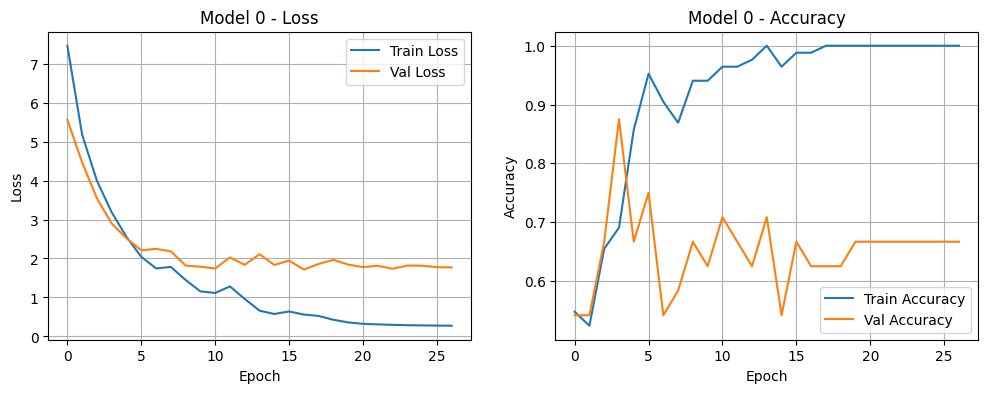

100%|██████████| 1/1 [02:19<00:00, 139.91s/it]


In [ ]:
ENSEMBLE_COUNT = 1
instance_shape = train_bags[0][0].shape
models = [create_model(instance_shape) for _ in range(ENSEMBLE_COUNT)]

trained_models = [
    train(train_bags, train_bags_labels, val_bags, val_bags_labels, model, idx)
    for idx, model in enumerate(tqdm(models))
]

## Evaluate Trained Model

In this section the trained model is evaluated using various metrics in the test set. Based on the Confusion Matrix and the Classification Report, it is clear that the model is performing far above the random estimator for both positive and negative classses, with relatively low misclassifications.  
Furthermore, the Receiver Operating Characteristic (ROC) and the Precision-Recall curves, highlight the model's high discriminative power in successfully predicting the GDP low/high class of each bag, given the night-time images. Once again, with scores AUC-0.79 and AP=0.9 the model's performance is clearly superior than the chance level of a random estimator.

In [ ]:
def predict(data, labels, trained_models):
    # Collect info per model.
    models_predictions = []
    models_attention_weights = []
    models_losses = []
    models_accuracies = []
    for model in trained_models:
        # Predict output classes on data.
        predictions = model.predict(data)
        models_predictions.append(predictions)
        # Create intermediate model to get MIL attention layer weights.
        intermediate_model = keras.Model(model.input, model.get_layer("alpha").output)
        # Predict MIL attention layer weights.
        intermediate_predictions = intermediate_model.predict(data)
        attention_weights = np.squeeze(np.swapaxes(intermediate_predictions, 1, 0))
        models_attention_weights.append(attention_weights)
        loss, accuracy = model.evaluate(data, labels, verbose=0)
        models_losses.append(loss)
        models_accuracies.append(accuracy)
    print(
        f"The average loss and accuracy are {np.sum(models_losses, axis=0) / ENSEMBLE_COUNT:.2f}"
        f" and {100 * np.sum(models_accuracies, axis=0) / ENSEMBLE_COUNT:.2f} % resp."
    )
    return (
        np.sum(models_predictions, axis=0) / ENSEMBLE_COUNT,
        np.sum(models_attention_weights, axis=0) / ENSEMBLE_COUNT,
        accuracy
    )

In [ ]:
# Evaluate and predict classes and attention scores on validation data.
class_predictions, attention_params, accuracy = predict(test_bags, test_bags_labels, trained_models)

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step   
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 5s/step
The average loss and accuracy are 1.83 and 80.95 % resp.


In [ ]:
# print the classification report
print(classification_report(test_bags_labels, np.argmax(class_predictions, axis=1)))

              precision    recall  f1-score   support

           0       0.71      0.83      0.77        24
           1       0.89      0.79      0.84        39

    accuracy                           0.81        63
   macro avg       0.80      0.81      0.80        63
weighted avg       0.82      0.81      0.81        63



In [ ]:
cm = confusion_matrix(test_bags_labels, np.argmax(class_predictions, axis=1))
print(f"Confusion Matrix:\n{cm}")

Confusion Matrix:
[[20  4]
 [ 8 31]]


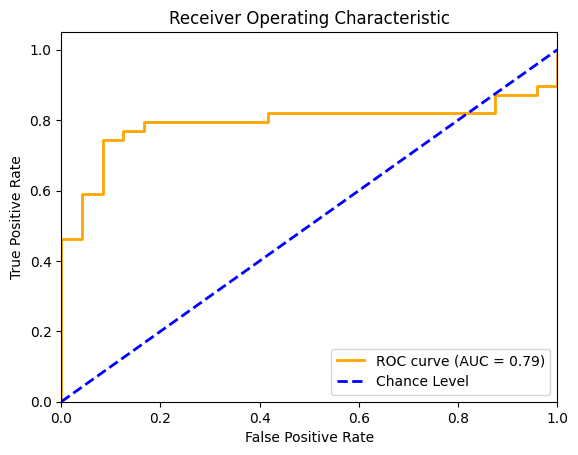

In [ ]:
# plot the ROC curve
fpr, tpr, thresholds = roc_curve(test_bags_labels, class_predictions[:, 1])
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='orange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--', label='Chance Level')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

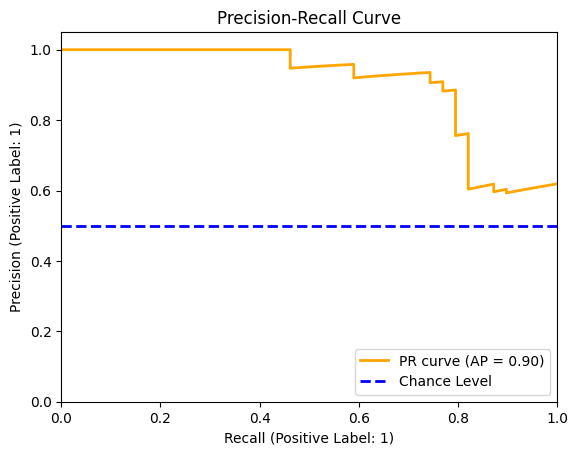

In [ ]:
# plot the Precision-Recall curve
precision, recall, thresholds = precision_recall_curve(test_bags_labels, class_predictions[:, 1])
pr_auc = auc(recall, precision)
plt.figure()
plt.plot(recall, precision, color='orange', lw=2, label='PR curve (AP = %0.2f)' % pr_auc)
plt.plot([0, 1], [0.5, 0.5], color='blue', lw=2, linestyle='--', label='Chance Level')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall (Positive Label: 1)')
plt.ylabel('Precision (Positive Label: 1)')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()

## Explore Attention Weights

This is an example of the Attention Weights retrieved from the test set bags. It can be shown that all bags attention weights summation equals to 1.

In [ ]:
attention_params.shape

(63, 50)

In [ ]:
np.sum(attention_params, axis=1)

array([0.99999994, 0.9999999 , 1.        , 1.0000001 , 0.99999994,
       1.0000001 , 1.        , 0.9999998 , 0.99999994, 1.0000001 ,
       0.99999994, 1.0000001 , 1.        , 0.99999994, 1.        ,
       1.        , 1.        , 0.99999994, 1.        , 0.99999994,
       1.        , 0.99999994, 0.99999994, 1.        , 1.        ,
       1.        , 1.0000001 , 1.        , 1.0000001 , 1.0000001 ,
       1.0000001 , 0.9999999 , 1.        , 0.99999994, 1.        ,
       0.9999999 , 1.0000001 , 0.99999994, 1.        , 0.99999994,
       0.99999994, 0.99999994, 1.        , 0.99999994, 1.        ,
       0.9999999 , 0.9999998 , 1.0000001 , 0.99999994, 0.9999998 ,
       1.        , 1.0000001 , 1.        , 0.9999999 , 0.9999999 ,
       0.99999994, 1.0000001 , 1.        , 0.9999999 , 1.0000002 ,
       1.        , 0.9999999 , 0.9999998 ], dtype=float32)

## Plot Bag Images with Highest Softmax Scores

This section visualizes the model's predictions and attention weights by plotting the images within bags of the test set that received the highest scores in after the softmax layer.   

The plots focus on a selection of correctly classified bags, showcasing 3 bags classified as "positive" and 3 bags classified as "negative." This allows us to examine the instances that contributed most to the correct classification of these bags.  

For each selected bag, the top 10 images with the highest attention weights are displayed. This highlights the specific image instances that the model considered most important for its prediction. By focusing on the highest attention weights, we gain insights into the visual patterns or features that the model has learned to associate with each class.


~~~~~~~~~~~~~~~~~ Class: 1 ~~~~~~~~~~~~~~~~~

Actual Label: 1, Predicted Label: 1, Softmax Score: [1.2141226e-04 9.9987847e-01]


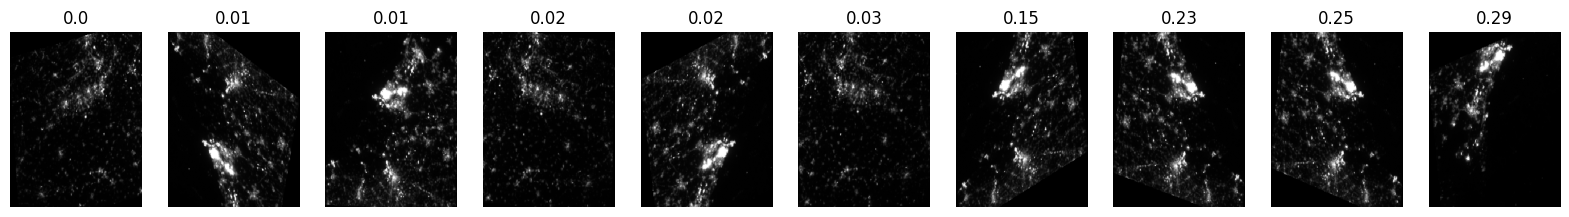

Actual Label: 1, Predicted Label: 1, Softmax Score: [1.0452762e-04 9.9989539e-01]


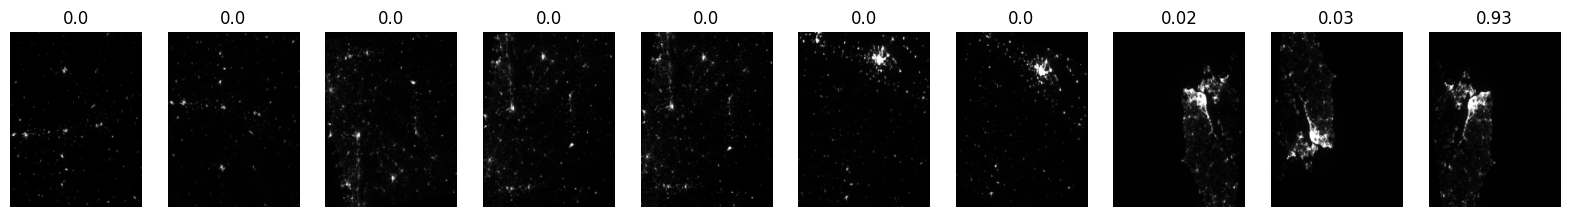

Actual Label: 1, Predicted Label: 1, Softmax Score: [1.2551918e-05 9.9998742e-01]


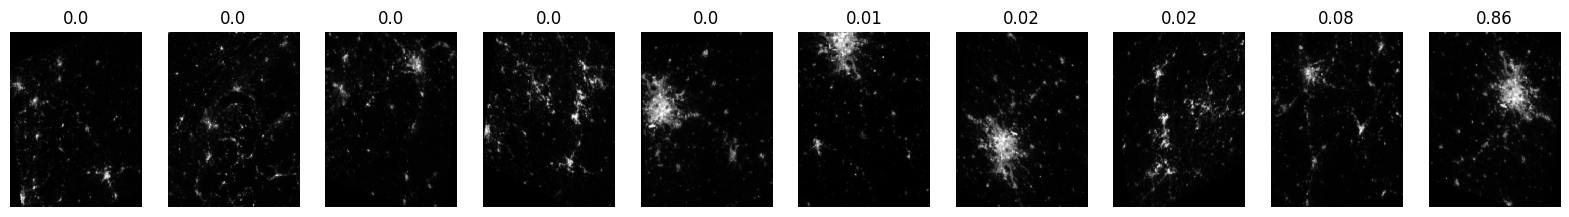


~~~~~~~~~~~~~~~~~ Class: 0 ~~~~~~~~~~~~~~~~~

Actual Label: 0, Predicted Label: 0, Softmax Score: [0.90655077 0.09344923]


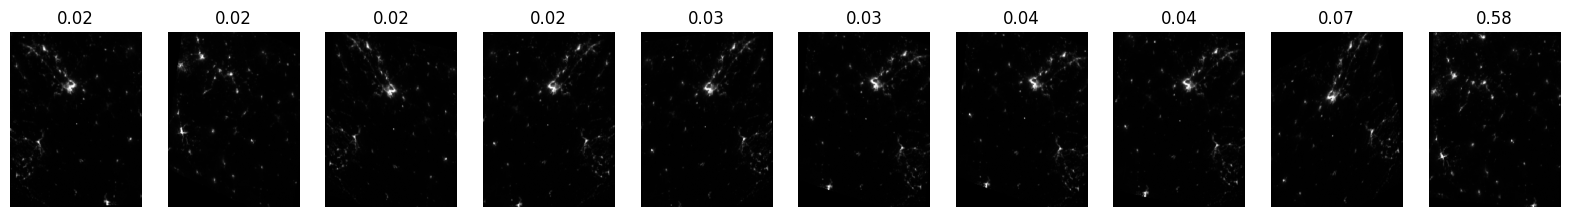

Actual Label: 0, Predicted Label: 0, Softmax Score: [0.95635736 0.04364268]


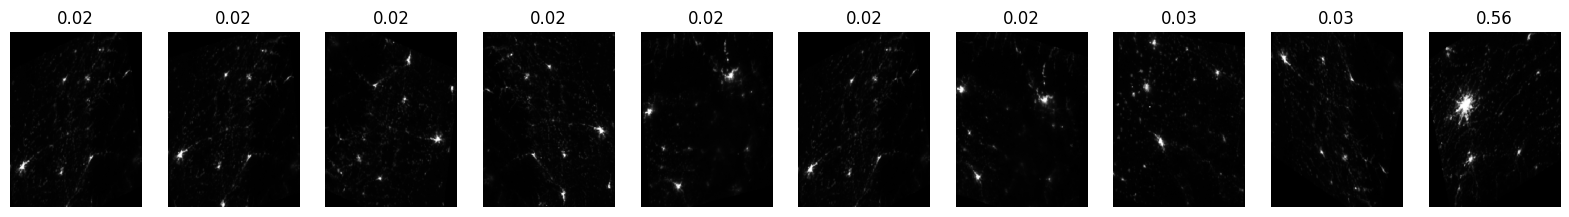

Actual Label: 0, Predicted Label: 0, Softmax Score: [0.9766261  0.02337393]


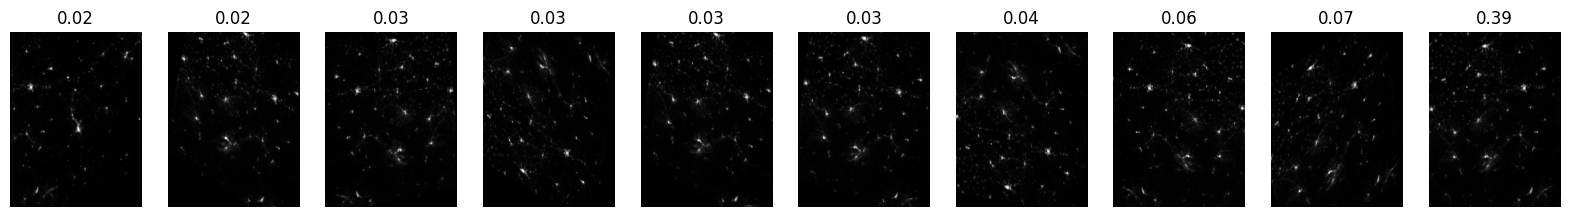

In [ ]:
def plot_results(data, labels, predictions, attention_weights):
    """Utility for plotting the top 10 images with highest attention weights
    for the 2 bags with the most certain predictions.

    Args:
      data: Input data that contains the bags of instances.
      labels: The associated bag labels of the input data.
      predictions: Class labels model predictions.
      attention_weights: Attention weights for each instance within the input data.
    """

    # Get prediction confidence for each bag
    confidence = np.max(predictions, axis=1)

    # Find indices of bags with highest confidence for each class
    positive_indices = np.where(predictions.argmax(1) == 1)[0]
    negative_indices = np.where(predictions.argmax(1) == 0)[0]
    top_pos = [-6, -5, -3]  # plot indicative examples of correct classification of positive class
    top_neg = [-8, -7, -5]  # plot indicative examples of correct classification of negative class
    top_positive_indices = positive_indices[np.argsort(confidence[positive_indices])[top_pos]]
    top_negative_indices = negative_indices[np.argsort(confidence[negative_indices])[top_neg]]

    # Plot the selected bags
    for bag_class, indices in [(1, top_positive_indices), (0, top_negative_indices)]:
        print(f"\n~~~~~~~~~~~~~~~~~ Class: {bag_class} ~~~~~~~~~~~~~~~~~\n")
        for i in indices:
            actual_label = labels[i][0]  # Get actual label from labels array
            print(f"Actual Label: {actual_label}, Predicted Label: {bag_class}, Softmax Score: {predictions[i]}")
            figure = plt.figure(figsize=(20, 10))

            # Get indices of top 10 images with highest attention weights
            top_10_indices = np.argsort(attention_weights[i])[-10:]

            # Plot the top 10 images
            for j, image_index in enumerate(top_10_indices):
                image = np.array(data)[image_index][i]
                figure.add_subplot(1, 10, j + 1)
                plt.grid(False)
                plt.axis('off')
                plt.title(np.around(attention_weights[i][image_index], 2))
                plt.imshow(image, cmap='gray')
            plt.show()

plot_results(test_bags, test_bags_labels,class_predictions, attention_params)

## Statistical (Chi-Square) Test

The Chi-Square test can be used to compare the observed and expected class frequencies in the confusion matrix. This can help assess the goodness of fit of the classification model, indicating how well the model’s predictions align with the actual class distributions.  
The Chi-Square test answers the question "Is there a significant association between what the model predicts and what the true labels are, or could the observed results have occurred just by random guessing?". With a p-value < 0.05, the test proves that the the model predictions are statistically dependent on the actual labels, thus the trained model is not predicting at random.

In [ ]:
# Perform the Chi-squared test
chi2, p, dof, expected = chi2_contingency(cm)

# Output the results
print(f"Chi-squared Statistic: {chi2:.4f}")
print(f"P-value: {p:.2e}")

# Optional interpretation
if p < 0.05:
    print("Result: Statistically significant association between actual and predicted labels (P-value < 0.05).")
else:
    print("Result: No statistically significant association between actual and predicted labels (P-value > 0.05).")

Chi-squared Statistic: 21.2701
P-value: 3.99e-06
Result: Statistically significant association between actual and predicted labels (P-value < 0.05).


The Chi-Square test performed on the model's confusion matrix computed earlier, yielded a statistic of 21.27 with 1 degree of freedom and a P-value of 3.99e-06. The P-value score which is lower than 0.05, indicates that there is a statistically significant association between the predicted and actual class labels, suggesting that the model's predictions are not due to random chance. This supports the conclusion that the classifier performs substantially better than a random estimator and captures relevant distinctions between the two classes of the given dataset.

## Save best model & Test Set

This functionality is helpful for the reproducibility of the final results.

In [ ]:
from google.colab import files
file_path = "/tmp/best_model_0.weights.h5"
files.download(file_path)

In [ ]:
# download locally from colab the test_bags and test_bags_labels to be able to reload them
import pickle
with open('test_bags.pkl', 'wb') as f:
    pickle.dump(test_bags, f)
with open('test_bags_labels.pkl', 'wb') as f:
    pickle.dump(test_bags_labels, f)
# download locally from colab the test_bags and test_bags_labels to be able to reload them
from google.colab import files
files.download('test_bags.pkl')
files.download('test_bags_labels.pkl')